<a href="https://colab.research.google.com/github/GeronimoQB/CT_Algoritmos/blob/main/2_Classification_algoritmos_train_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación supervisada en bosques
Notebook organizado **por algoritmo de clasificación**, con separación en **training, validation y testing**
y reporte de métricas de desempeño en los tres conjuntos.

> Nota: este es un ejemplo didáctico. Sustituye el bloque de *Datos de ejemplo* por tus propios datos forestales.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (6, 4)

## 1. Datos de ejemplo y preparación

En esta sección se genera un **conjunto de datos sintético** que imita variables comunes en inventarios forestales.
Sustituye este bloque por la carga de tu base real (por ejemplo, `pd.read_excel(...)`).

In [ ]:
# 🔁 Generar datos de ejemplo (reemplazar por tus datos reales)
np.random.seed(42)
n = 10000
data = {
    'Elevation': np.random.uniform(1500, 3000, n),
    'Aspect': np.random.uniform(0, 360, n),
    'Slope': np.random.uniform(0, 60, n),
    'DistanceToWater': np.random.exponential(scale=300, size=n),
    'SoilType': np.random.randint(1, 5, n),
    # Clase: tipo de bosque (0: Pino, 1: Encino, 2: Mezclado)
    'ForestType': np.random.randint(0, 3, n)
}
df = pd.DataFrame(data)

df.head()

,Elevation,Aspect,Slope,DistanceToWater,SoilType,ForestType
0,2061.810178,134.510695,43.799899,304.953152,4,1
1,2926.071460,119.848355,11.070720,184.463018,1,1
2,2597.990913,63.415409,20.798382,1001.454309,1,2
3,2397.987726,218.616001,39.796838,74.145761,4,1
4,1734.027961,171.584698,28.925361,265.915046,3,0


In [ ]:
# Resumen estadístico
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Elevation,10000.0,2241.239337,431.445190,1500.017452,1869.493303,2238.792926,2610.009522,2999.576510
Aspect,10000.0,181.630756,104.146038,0.056788,91.420489,182.122840,272.332520,359.972938
Slope,10000.0,30.003024,17.206425,0.002887,15.224875,30.124086,44.680431,59.994059
DistanceToWater,10000.0,298.371484,296.441782,0.001661,85.050148,207.962315,412.447620,2539.624837
SoilType,10000.0,2.486600,1.113708,1.000000,1.000000,2.000000,3.000000,4.000000
ForestType,10000.0,0.991100,0.815284,0.000000,0.000000,1.000000,2.000000,2.000000


### División en variables predictoras (X) y variable objetivo (y)

- **X**: variables ambientales / de sitio.
- **y**: tipo de bosque (clase a predecir).

Se hará una partición 60% **training**, 20% **validation** y 20% **testing**.

In [ ]:
# Definir X e y
X = df.drop(columns=['ForestType'])
y = df['ForestType']

# 1) Separar en training (60%) y un conjunto temporal (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# 2) Separar el conjunto temporal en validation (20%) y testing (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print('Tamaños:')
print('Training   :', X_train.shape[0])
print('Validation :', X_val.shape[0])
print('Testing    :', X_test.shape[0])

Tamaños:
Training   : 6000
Validation : 2000
Testing    : 2000


### Normalización Min-Max

Se aplica **MinMaxScaler** usando únicamente el conjunto de entrenamiento y luego se transforma validation y testing.
Esto es importante para evitar fuga de información (*data leakage*).

In [ ]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

## 2. Función auxiliar para evaluar modelos en training, validation y testing

La función siguiente:
- Ajusta el modelo usando únicamente el conjunto de **training**.
- Calcula **accuracy, precision, recall y F1** en los tres conjuntos.
- Imprime el `classification_report` para cada conjunto.
- Muestra la **matriz de confusión del conjunto de testing**.
- Devuelve un `DataFrame` con las métricas de los tres conjuntos.

In [ ]:
def evaluar_modelo_tres(modelo,
                        X_train, y_train,
                        X_val, y_val,
                        X_test, y_test,
                        nombre='Modelo'):
    """Entrena el modelo en training y evalúa en training, validation y testing."""

    modelo.fit(X_train, y_train)

    resultados = []
    predicciones = {}

    for X_split, y_split, split_name in [
        (X_train, y_train, 'Train'),
        (X_val,   y_val,   'Validation'),
        (X_test,  y_test,  'Test')
    ]:
        y_pred = modelo.predict(X_split)
        predicciones[split_name] = y_pred

        acc = accuracy_score(y_split, y_pred)
        prec = precision_score(y_split, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_split, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_split, y_pred, average='weighted', zero_division=0)

        print(f"\n=== {nombre} - {split_name} ===")
        print(f"Accuracy : {acc:0.3f}")
        print(f"Precision: {prec:0.3f}")
        print(f"Recall   : {rec:0.3f}")
        print(f"F1-score : {f1:0.3f}")

        print('\nReporte de clasificación:')
        print(classification_report(y_split, y_pred, zero_division=0))

        resultados.append({
            'Modelo': nombre,
            'Split': split_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1
        })

    # Matriz de confusión solo para el conjunto de testing
    cm = confusion_matrix(y_test, predicciones['Test'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de confusión - {nombre} (Test)')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

    return pd.DataFrame(resultados)

## Regresión Logística

La **regresión logística** es un modelo lineal para clasificación.
- Supone una relación aproximadamente lineal entre las variables de entrada y la logit de la probabilidad de cada clase.
- Es rápida, interpretable y sirve como **modelo base**.
- Hiperparámetro principal: `C` (inversa de la regularización: valores pequeños implican más regularización).

En este caso se usa la versión multinomial para varias clases.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Regresión Logística - Train ===
Accuracy : 0.343
Precision: 0.341
Recall   : 0.343
F1-score : 0.333

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.35      0.44      0.39      2021
           1       0.34      0.39      0.37      2012
           2       0.33      0.19      0.24      1967

    accuracy                           0.34      6000
   macro avg       0.34      0.34      0.33      6000
weighted avg       0.34      0.34      0.33      6000


=== Regresión Logística - Validation ===
Accuracy : 0.337
Precision: 0.335
Recall   : 0.337
F1-score : 0.329

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       673
           1       0.35      0.41      0.37       671
           2       0.32      0.20      0.24       656

    accuracy                           0.34      2000
   macro avg       0.34      0.34      0.33      2000
weighted avg       0.34 

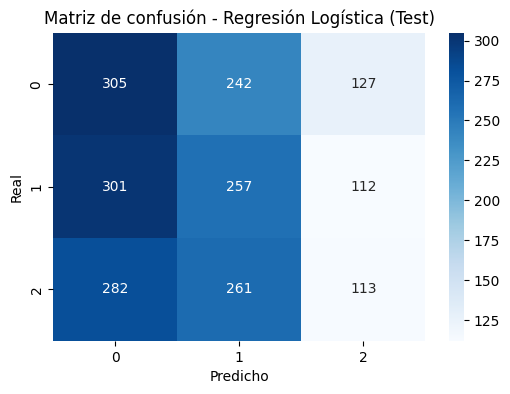

In [ ]:
modelo_lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
res_lr = evaluar_modelo_tres(
    modelo_lr,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    nombre='Regresión Logística'
)

## Máquinas de Vectores de Soporte (SVM)

Las **SVM** buscan el hiperplano que maximiza el margen entre clases.
- Funcionan bien en espacios de alta dimensión.
- Pueden usar distintos **kernels** (`linear`, `rbf`, `poly`).
- Hiperparámetros importantes: `C` (penalización) y `gamma` (en kernels no lineales).

Aquí se usa un kernel RBF con normalización Min-Max previa.


=== SVM (RBF) - Train ===
Accuracy : 0.389
Precision: 0.390
Recall   : 0.389
F1-score : 0.382

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.39      0.47      0.42      2021
           1       0.39      0.44      0.41      2012
           2       0.40      0.25      0.31      1967

    accuracy                           0.39      6000
   macro avg       0.39      0.39      0.38      6000
weighted avg       0.39      0.39      0.38      6000


=== SVM (RBF) - Validation ===
Accuracy : 0.326
Precision: 0.322
Recall   : 0.326
F1-score : 0.317

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.39      0.36       673
           1       0.33      0.40      0.36       671
           2       0.30      0.18      0.23       656

    accuracy                           0.33      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32      0.33      0.32 

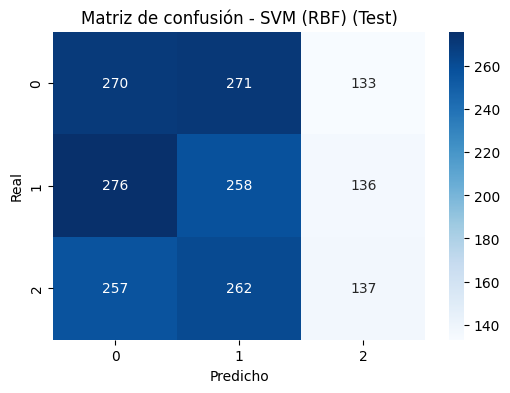

In [ ]:
modelo_svm = SVC(kernel='rbf', C=1.0, gamma='scale')
res_svm = evaluar_modelo_tres(
    modelo_svm,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    nombre='SVM (RBF)'
)

## K-Vecinos más Cercanos (K-NN)

El algoritmo **k-NN** clasifica un punto según la mayoría de sus *k* vecinos más cercanos en el espacio de características.
- No tiene fase de entrenamiento explícita, el cálculo ocurre al predecir.
- Es sensible a la escala de las variables (por eso usamos datos normalizados).
- Hiperparámetro clave: `n_neighbors` (número de vecinos).


=== K-NN (k=7) - Train ===
Accuracy : 0.528
Precision: 0.532
Recall   : 0.528
F1-score : 0.526

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.51      0.62      0.56      2021
           1       0.52      0.52      0.52      2012
           2       0.56      0.44      0.50      1967

    accuracy                           0.53      6000
   macro avg       0.53      0.53      0.53      6000
weighted avg       0.53      0.53      0.53      6000


=== K-NN (k=7) - Validation ===
Accuracy : 0.315
Precision: 0.313
Recall   : 0.315
F1-score : 0.311

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.32      0.39      0.35       673
           1       0.31      0.32      0.32       671
           2       0.30      0.23      0.27       656

    accuracy                           0.31      2000
   macro avg       0.31      0.31      0.31      2000
weighted avg       0.31      0.31      0.3

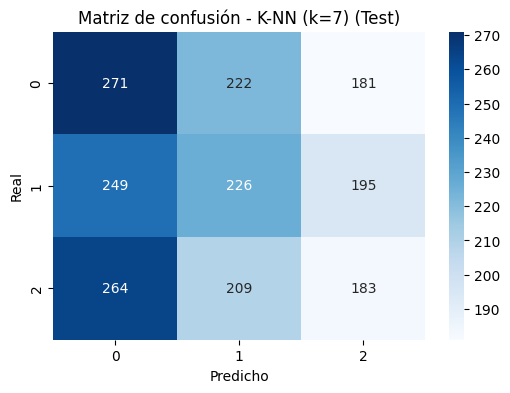

In [ ]:
modelo_knn = KNeighborsClassifier(n_neighbors=7)
res_knn = evaluar_modelo_tres(
    modelo_knn,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    nombre='K-NN (k=7)'
)

## Árbol de Decisión

Un **árbol de decisión** divide recursivamente el espacio de atributos en regiones más homogéneas en términos de la clase.
- Fácil de interpretar (reglas tipo 'si-entonces').
- Tiende a sobreajustar si no se poda o limita su profundidad.
- Hiperparámetros importantes: `max_depth`, `min_samples_split`, `min_samples_leaf`.

Los árboles no requieren normalización de variables, por lo que se usan las variables en su escala original.


=== Árbol de decisión (max_depth=5) - Train ===
Accuracy : 0.369
Precision: 0.427
Recall   : 0.369
F1-score : 0.318

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.36      0.61      0.45      2021
           1       0.37      0.44      0.40      2012
           2       0.56      0.05      0.10      1967

    accuracy                           0.37      6000
   macro avg       0.43      0.37      0.32      6000
weighted avg       0.43      0.37      0.32      6000


=== Árbol de decisión (max_depth=5) - Validation ===
Accuracy : 0.324
Precision: 0.318
Recall   : 0.324
F1-score : 0.272

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.57      0.42       673
           1       0.31      0.36      0.33       671
           2       0.31      0.03      0.06       656

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.27      2000


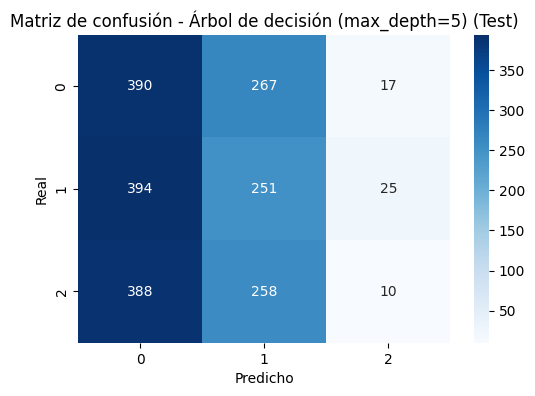

In [ ]:
modelo_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
res_tree = evaluar_modelo_tres(
    modelo_tree,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    nombre='Árbol de decisión (max_depth=5)'
)

## Bosque Aleatorio (Random Forest)

Un **Random Forest** combina muchos árboles de decisión entrenados sobre distintas muestras del conjunto de datos y subconjuntos de variables.
- Reduce la varianza y mejora la capacidad de generalización.
- Proporciona importancia de variables.
- Hiperparámetros clave: `n_estimators`, `max_depth`.


=== Random Forest - Train ===
Accuracy : 0.794
Precision: 0.803
Recall   : 0.794
F1-score : 0.795

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2021
           1       0.73      0.86      0.79      2012
           2       0.88      0.73      0.80      1967

    accuracy                           0.79      6000
   macro avg       0.80      0.79      0.79      6000
weighted avg       0.80      0.79      0.79      6000


=== Random Forest - Validation ===
Accuracy : 0.325
Precision: 0.324
Recall   : 0.325
F1-score : 0.322

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.35      0.34       673
           1       0.32      0.37      0.34       671
           2       0.32      0.25      0.28       656

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32      0.32   

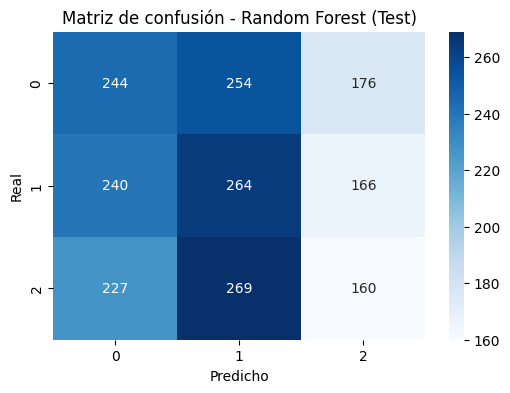

In [ ]:
modelo_rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
res_rf = evaluar_modelo_tres(
    modelo_rf,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    nombre='Random Forest'
)

## Gradient Boosting

Los métodos de **boosting** (como Gradient Boosting) construyen árboles de decisión de forma secuencial,
donde cada nuevo árbol corrige los errores del conjunto anterior.
- Pueden lograr alta precisión pero son más sensibles a los hiperparámetros.
- Hiperparámetros clave: `n_estimators`, `learning_rate`, `max_depth`.


=== Gradient Boosting - Train ===
Accuracy : 0.580
Precision: 0.583
Recall   : 0.580
F1-score : 0.579

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      2021
           1       0.56      0.65      0.60      2012
           2       0.62      0.51      0.56      1967

    accuracy                           0.58      6000
   macro avg       0.58      0.58      0.58      6000
weighted avg       0.58      0.58      0.58      6000


=== Gradient Boosting - Validation ===
Accuracy : 0.325
Precision: 0.324
Recall   : 0.325
F1-score : 0.323

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.33      0.34      0.34       673
           1       0.32      0.36      0.34       671
           2       0.32      0.27      0.29       656

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32     

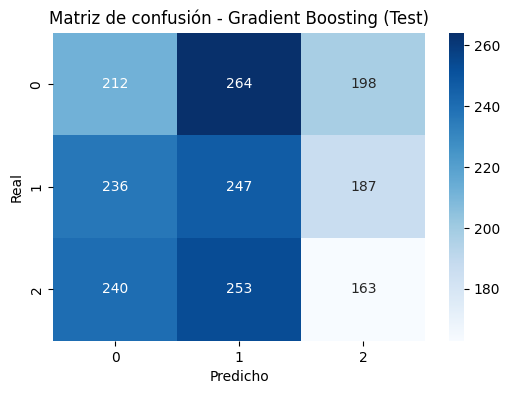

In [ ]:
modelo_gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)
res_gb = evaluar_modelo_tres(
    modelo_gb,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    nombre='Gradient Boosting'
)

## Naive Bayes (GaussianNB)

El clasificador **Naive Bayes** asume independencia condicional entre las variables dado la clase.
- Muy rápido y simple.
- Suele funcionar bien como modelo base, incluso con datos de alta dimensión.
- Se usa con distintos supuestos (gaussiano, multinomial, bernoulli).


=== Naive Bayes Gaussiano - Train ===
Accuracy : 0.347
Precision: 0.346
Recall   : 0.347
F1-score : 0.336

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.40      0.37      2021
           1       0.35      0.45      0.40      2012
           2       0.34      0.19      0.24      1967

    accuracy                           0.35      6000
   macro avg       0.35      0.35      0.34      6000
weighted avg       0.35      0.35      0.34      6000


=== Naive Bayes Gaussiano - Validation ===
Accuracy : 0.335
Precision: 0.334
Recall   : 0.335
F1-score : 0.326

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.37      0.36       673
           1       0.33      0.44      0.38       671
           2       0.33      0.19      0.24       656

    accuracy                           0.34      2000
   macro avg       0.33      0.33      0.32      2000
weighted avg       0

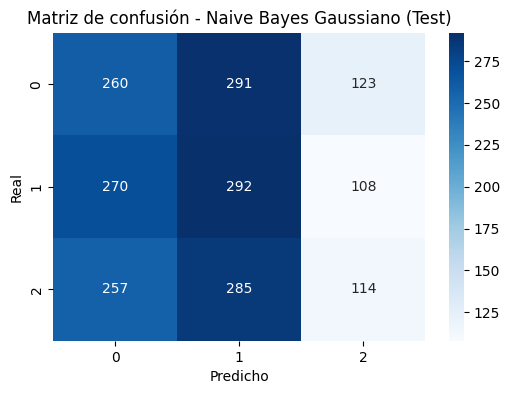

In [ ]:
modelo_nb = GaussianNB()
res_nb = evaluar_modelo_tres(
    modelo_nb,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    nombre='Naive Bayes Gaussiano'
)

## Red Neuronal Multicapa (MLP)

Una **red neuronal multicapa (MLP)** aprende representaciones no lineales mediante capas ocultas.
- Capaz de aproximar relaciones complejas.
- Requiere ajustar el número de neuronas y capas, la tasa de aprendizaje y el número de iteraciones.
- Más costosa computacionalmente que modelos lineales simples.

Las redes neuronales son sensibles a la escala de las variables, por lo que se usan los datos normalizados.


=== MLP (64-32) - Train ===
Accuracy : 0.425
Precision: 0.427
Recall   : 0.425
F1-score : 0.420

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.42      0.57      0.48      2021
           1       0.44      0.36      0.40      2012
           2       0.43      0.34      0.38      1967

    accuracy                           0.43      6000
   macro avg       0.43      0.42      0.42      6000
weighted avg       0.43      0.43      0.42      6000


=== MLP (64-32) - Validation ===
Accuracy : 0.337
Precision: 0.337
Recall   : 0.337
F1-score : 0.333

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       673
           1       0.33      0.30      0.32       671
           2       0.34      0.27      0.30       656

    accuracy                           0.34      2000
   macro avg       0.34      0.34      0.33      2000
weighted avg       0.34      0.34      0

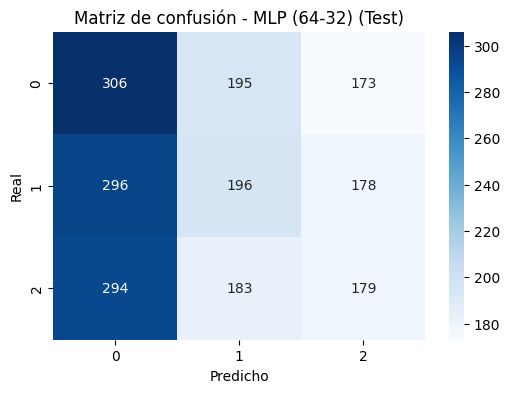

In [ ]:
#'adam' Optimización adaptativa moderna; 'sgd' Gradiente descendente estocástico; 'lbfgs' Optimizador cuasi-Newton
modelo_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                           solver='adam', max_iter=500, random_state=42)
res_mlp = evaluar_modelo_tres(
    modelo_mlp,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    X_test_scaled,  y_test,
    nombre='MLP (64-32)'
)

## 3. Comparación de métricas entre modelos y conjuntos

En este bloque se recopilan las métricas de todos los modelos y los tres conjuntos
(**Train**, **Validation**, **Test**) para facilitar la comparación.

In [ ]:
resultados = pd.concat([
    res_lr,
    res_svm,
    res_knn,
    res_tree,
    res_rf,
    res_gb,
    res_nb,
    res_mlp
], ignore_index=True)

# Ordenar por modelo and tipo de conjunto
resultados = resultados.sort_values(by=['Modelo', 'Split'])
resultados

,Modelo,Split,Accuracy,Precision,Recall,F1
17,Gradient Boosting,Test,0.311000,0.309710,0.311000,0.309126
15,Gradient Boosting,Train,0.579833,0.583381,0.579833,0.578668
16,Gradient Boosting,Validation,0.324500,0.324475,0.324500,0.323377
8,K-NN (k=7),Test,0.340000,0.339102,0.340000,0.338189
6,K-NN (k=7),Train,0.528333,0.531622,0.528333,0.526111
7,K-NN (k=7),Validation,0.314500,0.313255,0.314500,0.311401
23,MLP (64-32),Test,0.340500,0.340259,0.340500,0.335937
21,MLP (64-32),Train,0.425333,0.427432,0.425333,0.419720
22,MLP (64-32),Validation,0.336500,0.336663,0.336500,0.332623
20,Naive Bayes Gaussiano,Test,0.333000,0.332413,0.333000,0.321859
